In [1]:
import time, timeit
from functools import partial
%pylab inline
#import iam_hdf5_iterator
import hdf5_iterator
reload(hdf5_iterator)
import minibatcher
reload(minibatcher)
from minibatcher import MiniBatcher
from preprocessing.segmentation import original_connected
import CoffeeStainer
reload(CoffeeStainer)
from PIL import Image
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('hdf5_iterator').setLevel(logging.INFO)
logging.getLogger('hdf5_iterator.viz_tools.array_to_png').setLevel(logging.INFO)
logging.getLogger('hdf5_iterator.minibatcher').setLevel(logging.ERROR)
logging.getLogger('minibatcher').setLevel(logging.ERROR)

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4004)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib
['', '/usr/local/lib/python2.7/dist-packages/Keras-0.3.2-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/tornado-4.1-py2.7-linux-x86_64.egg', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/python2.7/dist-packages/wx-3.0-gtk2', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/root/.ipython', '..', '..', '../..']


In [2]:
def plot_shingles(batch, nr_to_plot, nr_per_row=3):
    nr_rows = nr_to_plot // nr_per_row + min(nr_to_plot % nr_per_row, 1)
    for row_i in range(nr_rows):
        for col_i in range(nr_per_row):
            subplot_cell_id = row_i * nr_per_row + col_i + 1
            # handle partial final row case
            if subplot_cell_id > nr_to_plot:
                break
            
            batch_img = batch[subplot_cell_id-1]
            
            plt.subplot(nr_rows, nr_per_row, subplot_cell_id)
            plt.imshow(-batch_img, cmap="gray")
            plt.gca().axes.get_xaxis().set_ticks([])
            plt.gca().axes.get_yaxis().set_ticks([])
            
    
    
def demo_iteration(nmec_hdf5,
        shingle_size,
        batch_size=32,
        num_authors=50,
        num_forms_per_author=8,
        stdev_threshold=10.,
        add_rotation=False):
    print "Iteration Demo"
    
    # Pre- and post-processing functions
    #nmec_pre = hdf5_iterator.nmec_pre
    
    def iam_forms_pre(x, rng, **kwargs):
        # Chop the top and bottom off
        x_new = x[700:2700]
        # rotate
        x_angle = np.asarray(Image.fromarray(x_new.squeeze()).rotate(7.5*rng.randn()))
        return x_angle
    
    def iam_forms_post(x, **kwargs):
        x_new = 1 - x/255.
        return x_new

    def nmec_pre(x, **kwargs):
        return x
    
    def nmec_post(x, **kwargs):
        stainer = CoffeeStainer.CoffeeStainer()
        if np.random.random() > 0.98:
            x = stainer.get_rand_stain_w_random_brightness(Image.fromarray(x, 'L'), shingle_size, kwargs["rng"])
        x = hdf5_iterator.zero_one(x)
        return x
    
    nmec_iterator = hdf5_iterator.Hdf5MiniBatcher(nmec_hdf5, 
                         num_authors=num_authors, 
                         num_forms_per_author=num_forms_per_author,
                         shingle_dim=shingle_size,
                         batch_size=batch_size,
                         rng_seed=888,
                         preprocess=iam_forms_pre,
                         postprocess=iam_forms_post,
                         add_rotation=add_rotation,
                         stdev_threshold=stdev_threshold)    
    print "First batch: "
    mb = nmec_iterator.get_train_batch()
    plt.figure(figsize=(9,3))
    plot_shingles(mb[0], 18, 6)
    plt.show()
    print "Next batch: "
    mb2 = nmec_iterator.get_train_batch()
    plt.figure(figsize=(9,3))
    plot_shingles(mb2[0], 18, 6)
    plt.show()
    
    
def demo_ccs_iam(hdf5_path,
        shingle_size,
        batch_size=32,
        num_authors=50,
        num_forms_per_author=8,
        num_iters=10):
    print "Iteration Demo"
    
    # Pre- and post-processing functions
    #nmec_pre = hdf5_iterator.nmec_pre
    
    def iam_forms_pre(x, **kwargs):
        # Chop the top and bottom off
        x_new = x[700:2700]
        return x_new
    
    def iam_forms_post(x, **kwargs):
        x_new = 1 - x/255.
        return x_new
    
    rng = np.random.RandomState(888)
    
    def cc_getter(f, key):
        return original_connected.connected_component_getter(f, key,
                        shingle_size,
                        rng=rng,
                        fill_value=255,
                        preprocess_doc=iam_forms_pre,
                        postprocess=iam_forms_post)
    
    batch_object = hdf5_iterator.Hdf5GetterBatcher(hdf5_path, 
                         num_authors=num_authors,
                         num_forms_per_author=num_forms_per_author,
                         item_getter=cc_getter,
                         default_mode=MiniBatcher.TRAIN,
                         batch_size=32,
                         train_pct=.7, test_pct=.2, val_pct=.1,
                         rng=rng)    
    
    for i in range(num_iters):
        print "Batch {i}: ".format(i=i)
        get_t1 = time.clock()
        mb = batch_object.get_train_batch()
        get_t2 = time.clock()
        print "{0:.2f}s to retrieve".format(get_t2-get_t1)
        plt.figure(figsize=(9,3))
        plot_shingles(mb[0], 18, 6)
        plt.show()
   

        
def demo_sampling_repeats(hdf5_path,
             shingle_size,
             batch_size,
             num_authors,
             num_forms_per_author=-1):
    print "Sampling demo."
    print "Each batch should be different within iterations and identical across iterations."
    for iter_i in range(3):
        print "Iteration {0}.................".format(iter_i+1)
        iam_iterator = hdf5_iterator.Hdf5MiniBatcher(hdf5_path, 
                         num_authors=num_authors, 
                         num_forms_per_author=num_forms_per_author,
                         shingle_dim=shingle_size,
                         batch_size=batch_size,
                         rng_seed=888)
    
        print "First batch: "
        get_t1 = time.clock()
        mb = iam_iterator.get_train_batch()
        get_t2 = time.clock()
        print "Time to retrieve: {0}".format(get_t2-get_t1)
        plt.figure(figsize=(9,3))
        plot_shingles(mb[0], 18, 6)
        plt.show()
        print "Next batch: "
        mb2 = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,3))
        plot_shingles(mb2[0], 18, 6)
        plt.show()
        
    print "No repeats demo"
    print "The probability of a repeated shingle in a single epoch should be very small."
    iam_iterator = hdf5_iterator.Hdf5MiniBatcher(hdf5_path, 
                     num_authors=num_authors, 
                     num_forms_per_author=num_forms_per_author,
                     shingle_dim=shingle_size,
                     batch_size=batch_size)
    nr_iters = 5
    unique_imgs = set()
    for i in range(nr_iters):
        print "Batch {0}".format(i)
        mb = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,9))
        plot_shingles(mb[0], batch_size, 6)
        plt.show()
        unique_imgs.update([mb[0][img_i].tostring() for img_i in range(batch_size)])
        print "**Unique shingles so far: {0} (should be {1})**".format(len(unique_imgs), 
                                                                       (i+1) * batch_size)

def main():
    hdf5path = "/fileserver/iam/iam-binary/iam_author_forms_bin.hdf5"
    stdev_threshold=20
    demo_time = timeit.timeit(partial(demo_ccs_iam,  hdf5path, shingle_size=(120,120),
                                                     num_authors=90,
                                                     num_forms_per_author=4),
                             number=1)
    print "{0} seconds".format(demo_time)
        
    
       
    
    

Automatic pdb calling has been turned OFF
Iteration Demo
Batch 0: 
59.98s to retrieve


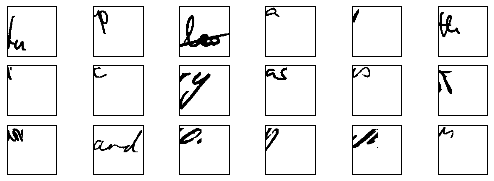

Batch 1: 
43.87s to retrieve


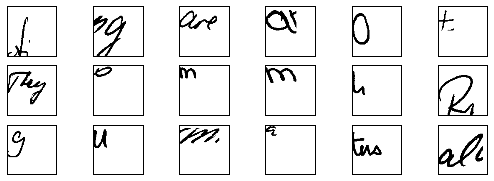

Batch 2: 
50.84s to retrieve


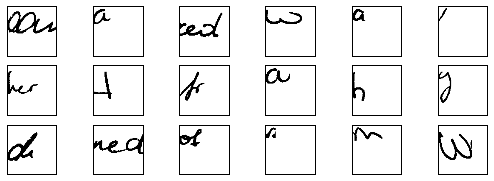

Batch 3: 
51.26s to retrieve


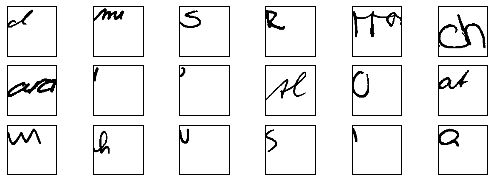

Batch 4: 
25.43s to retrieve


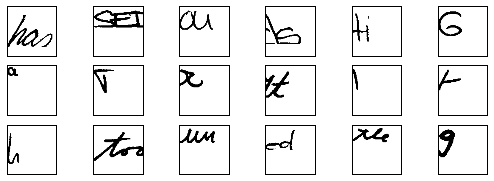

Batch 5: 
46.38s to retrieve


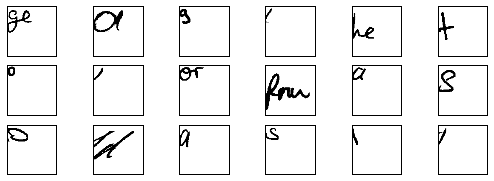

Batch 6: 
10.11s to retrieve


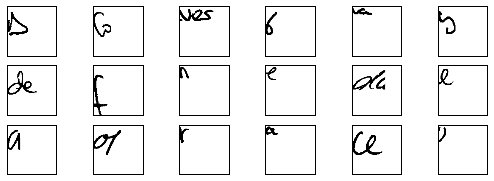

Batch 7: 
28.88s to retrieve


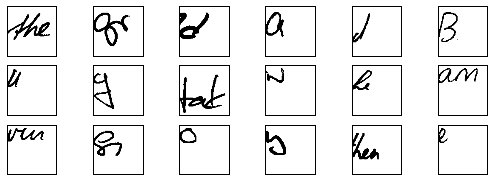

Batch 8: 
27.33s to retrieve


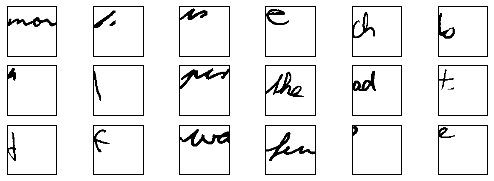

Batch 9: 
26.23s to retrieve


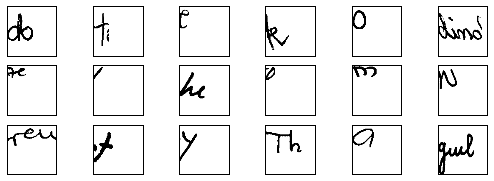

377.50437808 seconds


In [3]:
# Main Test Cell
%pdb off
main()